In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!ls -lash /content/drive/MyDrive/cs231n/student-radar/paper/data/real/

total 685M
615M -rw------- 1 root root 615M May  4  2024 EXP_17_M.h5
 37M -rw------- 1 root root  37M Jun  5 04:11 real_ra.npy
 34M -rw------- 1 root root  34M Jun  5 22:11 TABULAR_CSV_ALL_CLASSES.csv


# Loading

In [4]:
def load_exps_and_labels(detections):
    all_exps, all_labels = [], []

    counter = 0

    for exp_name, data in detections.groupby('Exp'):
        counter += 1

        try:
            file = h5py.File(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/real/{exp_name}.h5', 'r')
        except:
            print(f'Couldnt load exp {exp_name}')
            continue

        exp = []

        for channel_id in range(1, 17):
            channel = file[f'Chn{channel_id}']
            exp.append(channel)

        exp = np.swapaxes(exp, 1, 0)

        chirps_ids = []

        for _, (frame_id, depth) in data[['Frame', 'Depth']].iterrows():
            chirps_ids = chirps_ids + list(np.linspace(frame_id*127, frame_id*128+127, 128, dtype=np.uint16))
            all_labels = all_labels + list(np.repeat(depth, 128))

        exp = exp[chirps_ids]

        all_exps = all_exps + list(exp)

    all_exps = np.array(all_exps)
    all_labels = np.array([all_labels]).T
    all_exps[:, :, :50] = 0

    return all_exps.astype(np.float32), all_labels.astype(np.float32)

def split_chirps_by_frame(chirp_data, labels, chirps_per_frame=128, train_ratio=0.9, seed=1729):
    """
    Splits chirp data into train and test sets, preserving frame boundaries.

    Args:
        chirp_data: shape (N, 1024, 16)
        labels: shape (N, 1)
        chirps_per_frame: number of chirps in one radar frame
        train_ratio: fraction of frames to use for training
        seed: random seed for shuffling (integer)

    Returns:
        (train_chirps, train_labels), (test_chirps, test_labels)
    """
    np.random.seed(seed)

    total_chirps = chirp_data.shape[0]
    num_frames = total_chirps // chirps_per_frame

    # Trim to full frames
    total_chirps = num_frames * chirps_per_frame
    chirp_data = chirp_data[:total_chirps]
    labels = labels[:total_chirps]

    # Reshape into frames
    chirp_data = chirp_data.reshape(num_frames, chirps_per_frame, 1024, 16)
    labels = labels.reshape(num_frames, chirps_per_frame, 1)

    # Shuffle frames
    indices = np.random.permutation(num_frames)
    chirp_data = chirp_data[indices]
    labels = labels[indices]

    # Split into train/test by frames
    train_frames = int(train_ratio * num_frames)

    train_chirps = chirp_data[:train_frames].reshape(-1, 1024, 16)
    train_labels = labels[:train_frames].reshape(-1, 1)

    test_chirps = chirp_data[train_frames:].reshape(-1, 1024, 16)
    test_labels = labels[train_frames:].reshape(-1, 1)

    return (train_chirps, train_labels), (test_chirps, test_labels)

def split_chirps_suffled(data, labels_generator, labels_discriminator, validation_split=0.2, seed = 1729):
    #print(path_data)

    #data = np.load(path_data)
    #labels_generator, labels_discriminator = np.load(path_labels, allow_pickle=True)

    assert len(data) == len(labels_generator) == len(labels_discriminator), \
    f"Mismatch in lengths: data={len(data)}, labels_generator={len(labels_generator)}, labels_discriminator={len(labels_discriminator)}"

    num_samples = len(data)
    split_idx = int(num_samples * (1 - validation_split))

    # Shuffle before splitting
    np.random.seed(seed)  # default seed is the same as used in training and called right before the shuffle
    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels_generator = labels_generator[indices]
    labels_discriminator = labels_discriminator[indices]

    # Split off training data that was actually fed into the tf models
    train_data = data[:split_idx]
    train_labels_generator = labels_generator[:split_idx]
    train_labels_discriminator = labels_discriminator[:split_idx]

    val_data = data[split_idx:]
    val_labels_generator = labels_generator[split_idx:]
    val_labels_discriminator = labels_discriminator[split_idx:]

    print(f'\nTrain: {len(train_labels_generator)}')
    print(f'\nVal: {len(val_labels_generator)}')

    return (train_data, train_labels_generator, train_labels_discriminator), (val_data, val_labels_generator, val_labels_discriminator)

In [5]:
FILE_NAME = 'EXP_17_M'

In [6]:
#!find /content/drive/MyDrive -name "TABULAR_CSV_ALL_CLASSES.csv"

In [7]:
all_detections = pd.read_csv('/content/drive/MyDrive/cs231n/student-radar/paper/data/real/TABULAR_CSV_ALL_CLASSES.csv')

In [8]:
detections = all_detections[all_detections['Exp'].str.contains(FILE_NAME)].query('Class == "Motorcycle" and Depth <= 25')

In [9]:
pd.unique(detections['Exp'])

array(['EXP_17_M'], dtype=object)

In [10]:
raw_data, labels = load_exps_and_labels(detections)

In [11]:
print(labels.shape)
print(len(np.unique(labels)))

(6144, 1)
47


In [12]:
import os

In [13]:
os.makedirs('/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed', exist_ok=True)

In [14]:
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps.npy', raw_data)

In [15]:
raw_data = np.swapaxes(raw_data, 2, 1)

In [16]:
raw_data.shape

(6144, 1024, 16)

In [17]:
(train_data, train_labels), (test_data, test_labels) = split_chirps_by_frame(raw_data, labels, chirps_per_frame=128, train_ratio=0.9)
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(5504, 1024, 16)
(5504, 1)
(640, 1024, 16)
(640, 1)


# Scale

## Data Scale

In [18]:
print(f'Mean: {train_data.mean()}, Std: {train_data.std()}')

Mean: 183.6184539794922, Std: 1001.6725463867188


In [19]:
data_min = train_data.min()
data_max = train_data.max()

In [20]:
print(f'Min: {data_min}, Max: {data_max}')

Min: -3884.0, Max: 4772.0


In [21]:
a, b = -1, 1

In [22]:
np.subtract(train_data, data_min, out=train_data)
np.multiply(train_data, (b - a), out=train_data)
np.divide(train_data, (data_max - data_min), out=train_data)
train_data = np.add(train_data, a, out=train_data)

np.subtract(test_data, data_min, out=test_data)
np.multiply(test_data, (b - a), out=test_data)
np.divide(test_data, (data_max - data_min), out=test_data)
test_data = np.add(test_data, a, out=test_data)

In [23]:
normalized_mean = train_data.mean()

In [24]:
print(f'Mean: {normalized_mean}')

Mean: -0.060162272304296494


In [25]:
print(f'Mean: {test_data.mean()}')

Mean: -0.06016920134425163


### Label Generator Scale

In [26]:
# labels_mean = labels.mean() # 10.94125747680664
# labels_std = labels.std() # 7.1789422035217285
labels_mean = train_labels.mean()
labels_std = train_labels.std()

In [27]:
print(f'Mean: {labels_mean}, Std: {labels_std}')

Mean: 10.94125747680664, Std: 7.1789422035217285


In [28]:
print(f'Mean: {test_labels.mean()}, Std: {test_labels.std()}')

Mean: 11.325227737426758, Std: 7.286496639251709


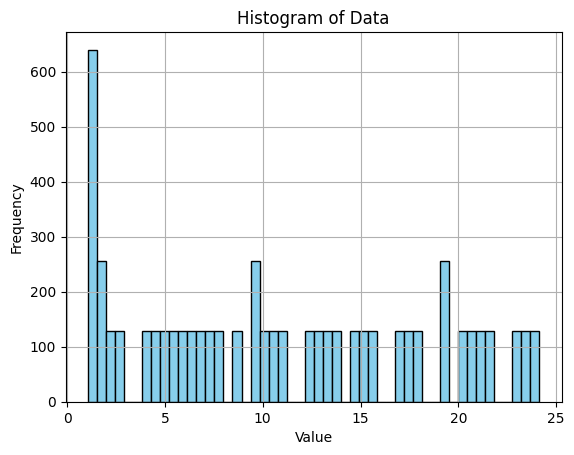

In [29]:
plt.hist(train_labels, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [30]:
labels_generator_train = (train_labels - labels_mean) / labels_std
labels_generator_test = (test_labels - labels_mean) / labels_std

In [31]:
labels_generator_train.std()

np.float32(1.0)

In [32]:
labels_generator_test.std()

np.float32(1.014982)

### Label Discriminator Scale

In [33]:
labels_min = train_labels.min()
labels_max = train_labels.max()

In [34]:
labels_min, labels_max

(np.float32(1.0803078), np.float32(24.126875))

In [35]:
labels_discriminator_train = train_labels - labels_mean
labels_discriminator_train = a + ((labels_discriminator_train - labels_min)*(b-a)) / (labels_max - labels_min)

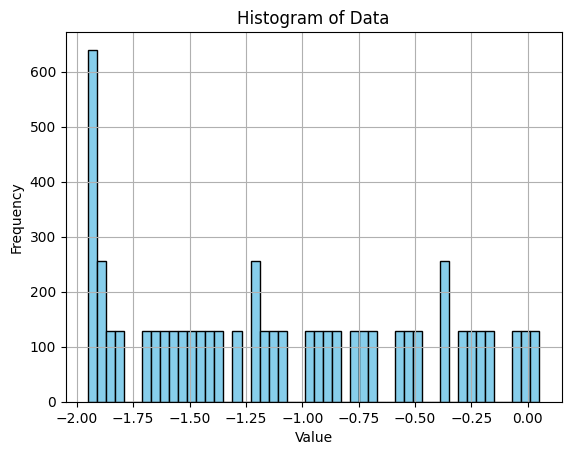

In [36]:
plt.hist(labels_discriminator_train, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [37]:
labels_discriminator_test = test_labels - labels_mean
labels_discriminator_test = a + ((labels_discriminator_test - labels_min)*(b-a)) / (labels_max  - labels_min)

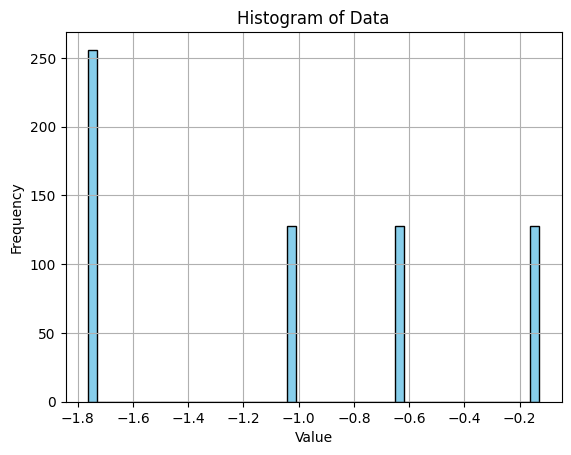

In [38]:
plt.hist(labels_discriminator_test, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [39]:
print(train_data.shape)
print(labels_generator_train.shape)
print(labels_discriminator_train.shape)
print(test_data.shape)
print(labels_generator_test.shape)
print(labels_discriminator_test.shape)

(5504, 1024, 16)
(5504, 1)
(5504, 1)
(640, 1024, 16)
(640, 1)
(640, 1)


# Save

In [40]:
#np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_scaled.npy', raw_data)
#np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_labels.npy', (labels_generator, labels_discriminator))
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_scaled_train.npy', train_data)
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_labels_train.npy', (labels_generator_train, labels_discriminator_train), allow_pickle=True)
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_scaled_test.npy', test_data)
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_labels_test.npy', (labels_generator_test, labels_discriminator_test), allow_pickle=True)

# Train and Validation Split Done the Same Way as in Tensorflow Training

In [41]:
(train_data_reduced, train_labels_generator_reduced, train_labels_discriminator_reduced), (val_data, val_labels_generator, val_labels_discriminator) = split_chirps_suffled(train_data, labels_generator_train, labels_discriminator_train)


Train: 4403

Val: 1101


In [42]:
print(train_data_reduced.shape)
print(train_labels_generator_reduced.shape)
print(train_labels_discriminator_reduced.shape)
print(val_data.shape)
print(val_labels_generator.shape)
print(val_labels_discriminator.shape)

(4403, 1024, 16)
(4403, 1)
(4403, 1)
(1101, 1024, 16)
(1101, 1)
(1101, 1)


In [43]:
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_scaled_train_reduced.npy', train_data_reduced)
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_labels_train_reduced.npy', (train_labels_generator_reduced, train_labels_discriminator_reduced), allow_pickle=True)
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_scaled_validation.npy', val_data)
np.save(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_labels_validation.npy', (val_labels_generator, val_labels_discriminator), allow_pickle=True)

In [44]:
_, temp = np.load(f'/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/{FILE_NAME}_chirps_labels_train_reduced.npy')
print(temp.shape)

(4403, 1)
